# nhật ký thực nghiệm 20-12-2025

thử nghiệm train model với mình nhóm:
- hợp chất hữu cơ có chứa nguyên tố khác (O, N, S, P,...)
- kim loại

để chứng minh đặc trưng về cấu trúc mạng tinh thể cũng như liên kết nội phân tử ảnh hưởng đến tính chất vật lý hóa học như nhiệt độ nóng chảy.

In [3]:
import json
import subprocess
import sys

def ensure_package(import_name: str, install_name: str | None = None) -> None:
    """Install a pip package if missing (best-effort)."""
    install_name = install_name or import_name
    result = subprocess.run(
        [sys.executable, '-m', 'pip', 'list', '--format=json'],
        check=True,
        capture_output=True,
        text=True,
    )
    installed = {pkg['name'].lower() for pkg in json.loads(result.stdout)}
    # Some packages have different import vs distribution names (e.g., rdkit-pypi -> rdkit)
    if import_name.lower() in installed or (install_name and install_name.lower() in installed):
        print(f'{import_name} already installed.')
        return
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', install_name])
    print(f'Installed {install_name} (import as {import_name}).')

# Install baseline modeling deps if missing (best-effort)
for pkg in [
    ('scikit-learn', 'scikit-learn'),
    ('lightgbm', 'lightgbm'),
    ('numpy', 'numpy'),
    ('pandas', 'pandas'),
    ('rdkit', 'rdkit'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn'),
]:
    try:
        ensure_package(pkg[0], pkg[1])
    except Exception as exc:
        print(f"Package install check failed for {pkg}: {exc}")





scikit-learn already installed.
lightgbm already installed.
numpy already installed.
pandas already installed.
rdkit already installed.
matplotlib already installed.
seaborn already installed.


In [4]:
from __future__ import annotations

from pathlib import Path
from typing import Any, Callable, Dict, Iterable, Optional, Tuple
import json
import multiprocessing as mp
import numpy as np
import pandas as pd


from joblib import Parallel, delayed

from rdkit import Chem, rdBase, RDLogger
from rdkit.Chem import AllChem, Crippen, Descriptors, Fragments, Lipinski, rdMolDescriptors, rdFingerprintGenerator
from rdkit.Chem.MACCSkeys import GenMACCSKeys
from rdkit.Chem.EState import AtomTypes as EAtomTypes

try:
    from rdkit.Chem.Scaffolds import MurckoScaffold
except Exception:
    MurckoScaffold = None

RDLogger.DisableLog('rdApp.*')
rdBase.DisableLog('rdApp.*')

DATA_DIR = Path('result/data')
TRAIN_PATH = DATA_DIR / 'melting_point_features_with_type.csv'


OUTPUT_DIR = Path('result/outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MORGAN_BITS = 512
MORGAN_RADIUS = 2
USE_MACCS = True
COMPUTE_3D = True
MAX_ITERS_3D = 0  

def save_results(timestamp: str = '', params: dict = None, best_iteration: int = None, valid_score: float = None, additional_score: dict = None, name: str = '') -> None:
    results = {
        'model_params': params,
        'best_iteration': best_iteration,
        'valid_score': valid_score,
        'additional_score': additional_score or {}
    }
    if timestamp:
        results['timestamp'] = timestamp
    results_path = OUTPUT_DIR / f'{name}_results{("_" + timestamp) if timestamp else "_unknown"}.json'
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)


def save_model(timestamp: str = '', model: object = None, name: str = '') -> None:
    model_path = OUTPUT_DIR / f'{name}{("_" + timestamp) if timestamp else "_unknown"}.joblib'
    import joblib
    joblib.dump(model, model_path)


def create_timestamp() -> str:
    from datetime import datetime
    return datetime.now().strftime('%Y%m%d_%H%M%S')

In [5]:
df_train_feat = pd.read_csv(TRAIN_PATH)

In [6]:
# Build X/y from the featurized training frame
assert 'Tm' in df_train_feat.columns, "Expected target column 'Tm' in df_train_feat"
assert 'SMILES' in df_train_feat.columns, "Expected 'SMILES' column in df_train_feat"

work_df = df_train_feat.copy()
work_df = work_df.dropna(subset=['Tm']).reset_index(drop=True)


In [7]:
def reduce_memory_usage(df: pd.DataFrame) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type) in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isna(c_min) or pd.isna(c_max):
                continue
            if str(col_type).startswith('int'):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        elif col_type == object:
            num_unique = df[col].nunique(dropna=False)
            if num_unique / max(len(df), 1) < 0.5:
                df[col] = df[col].astype('category')
    return df


work_df = reduce_memory_usage(work_df)

In [8]:
# only use organic (heteroatom-containing) compounds for modeling
other_data = work_df[work_df['chem_type'] != 'organic (heteroatom-containing)']
work_df = work_df[work_df['chem_type'] == 'organic (heteroatom-containing)'].reset_index(drop=True)


feature_cols = [c for c in work_df.columns if c not in ('Tm', 'SMILES')]
X = work_df[feature_cols].select_dtypes(include=['number'])
y = work_df['Tm'].astype(float)

print('Rows used:', len(work_df))
print('Numeric features:', X.shape[1])
print('Target stats:', float(y.min()), float(y.mean()), float(y.max()))

Rows used: 9246
Numeric features: 937
Target stats: -698.7999877929688 242.31646436354637 4892.0


In [9]:
work_df.dtypes

SMILES                 object
Tm                    float32
MaxAbsEStateIndex     float32
MaxEStateIndex        float32
MinAbsEStateIndex     float32
                       ...   
SMI_branches            int16
SMI_ringDigits          int16
SMI_stereoAt             int8
SMI_ezSlashes            int8
chem_type            category
Length: 940, dtype: object

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import lightgbm as lgb


# train model với nhóm hợp chất hữu cơ có chứa nguyên tố khác (O, N, S, P,...)

In [11]:


X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# imputer = SimpleImputer(strategy='median')
# X_train_imp = imputer.fit_transform(X_train)
# X_valid_imp = imputer.transform(X_valid)

model = lgb.LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=100,
    reg_alpha=0.1,
    reg_lambda=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l1',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.455727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31210
[LightGBM] [Info] Number of data points in the train set: 7396, number of used features: 864
[LightGBM] [Info] Start training from score 284.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,2000
,subsample_for_bin,200000
,objective,'quantile'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,100


In [12]:
rmse = np.sqrt(np.mean((model.predict(X_valid) - y_valid) ** 2))
mae = np.mean(np.abs(model.predict(X_valid) - y_valid))
r2 = model.score(X_valid, y_valid)

print(f'Validation RMSE: {rmse:.4f}')
print(f'Validation MAE: {mae:.4f}')
print(f'Validation R²: {r2:.4f}')

# get timestamp
timestamp = create_timestamp()

# save model
save_model(timestamp=timestamp, model=model, name='lgbm_melting_point_model')


# save score
save_results(
    timestamp=timestamp,
    params=model.get_params(),
    best_iteration=model.best_iteration_,
    valid_score=model.best_score_['valid_0']['l1'],
    additional_score={
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    },
    name='lgbm_melting_point_model'
)

Validation RMSE: 167.2425
Validation MAE: 90.1225
Validation R²: 0.4304


In [13]:
# Outlier removal 
Tm = work_df['Tm'].astype(float)
 
lower = -250
upper = 750

mask = (Tm >= lower) & (Tm <= upper)
removed = int((~mask).sum())
total = int(len(work_df))
pct_removed = 100.0 * removed / total if total else 0.0

print(f"IQR bounds for Tm: [{lower:.3f}, {upper:.3f}]")
print(f"Removed outliers: {removed}/{total} ({pct_removed:.2f}%)")

# Apply filter
work_df = work_df.loc[mask].reset_index(drop=True)
feature_cols = [c for c in work_df.columns if c not in ('Tm', 'SMILES')]
X = work_df[feature_cols].select_dtypes(include=['number'])
y = work_df['Tm'].astype(float)
#y_transformed = np.sign(y) * np.log1p(np.abs(y)) add log transform

print('After outlier removal -> Rows:', len(work_df), 'Numeric features:', X.shape[1])


IQR bounds for Tm: [-250.000, 750.000]
Removed outliers: 332/9246 (3.59%)
After outlier removal -> Rows: 8914 Numeric features: 937


In [14]:
#train model with outlier removed data
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l1',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.967549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31061
[LightGBM] [Info] Number of data points in the train set: 7131, number of used features: 859
[LightGBM] [Info] Start training from score 291.200012


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,2000
,subsample_for_bin,200000
,objective,'quantile'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,100


In [15]:
rmse = np.sqrt(np.mean((model.predict(X_valid) - y_valid) ** 2))
mae = np.mean(np.abs(model.predict(X_valid) - y_valid))
r2 = model.score(X_valid, y_valid)

print(f'Validation RMSE: {rmse:.4f}')
print(f'Validation MAE: {mae:.4f}')
print(f'Validation R²: {r2:.4f}')


# save model
save_model(timestamp=timestamp, model=model, name='lgbm_melting_point_model_outlier_removed')
# save score
save_results(
    timestamp=timestamp,
    params=model.get_params(),
    best_iteration=model.best_iteration_,
    valid_score=model.best_score_['valid_0']['l1'],
    additional_score={
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    },
    name='lgbm_melting_point_model_outlier_removed'
)


Validation RMSE: 106.8265
Validation MAE: 67.7152
Validation R²: 0.6800


/tmp/ipykernel_22303/2801895017.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')


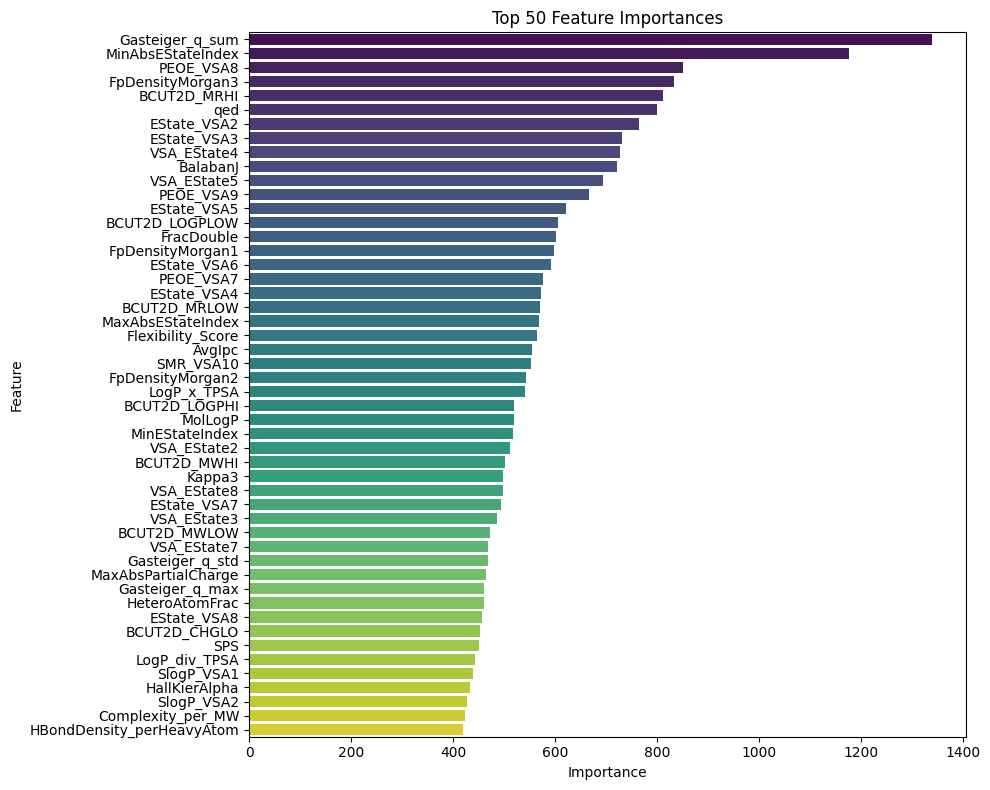

In [16]:
# plot of top 50 important features
importances = model.feature_importances_

import matplotlib.pyplot as plt
import seaborn as sns
feature_names = X.columns
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})
feature_importances = feature_importances.sort_values(by='importance', ascending=False).head(50)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('Top 50 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f'Organic_feature_importances_{timestamp}.png')
plt.show()



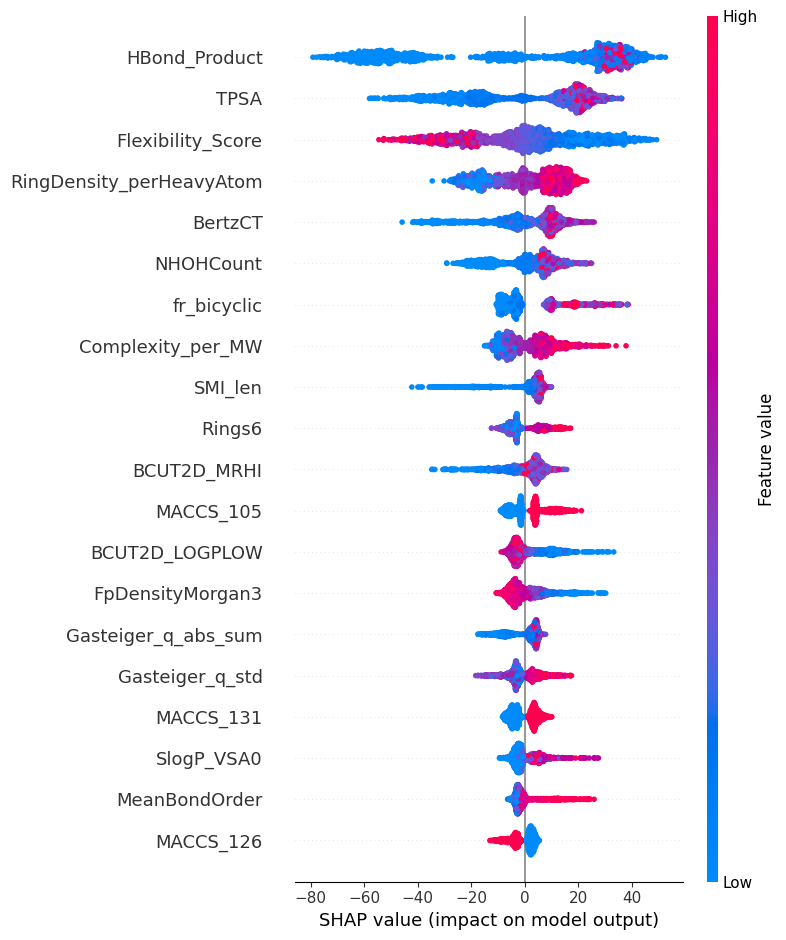

In [20]:
# shap plot
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid, show=False)
plt.savefig(OUTPUT_DIR / f'Organic_shap_summary_{timestamp}.png')

# train model với nhóm kim loại

In [21]:
this_data = other_data.copy()
work_df = this_data[this_data['chem_type'] == 'metal-containing (coordination/complex)'].reset_index(drop=True)

feature_cols = [c for c in work_df.columns if c not in ('Tm', 'SMILES')]
X = work_df[feature_cols].select_dtypes(include=['number'])
y = work_df['Tm'].astype(float)

print('Rows used:', len(work_df))
print('Numeric features:', X.shape[1])
print('Target stats:', float(y.min()), float(y.mean()), float(y.max()))



Rows used: 623
Numeric features: 937
Target stats: -5126.0 963.3806741069255 6170.0


In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l1',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7232
[LightGBM] [Info] Number of data points in the train set: 498, number of used features: 122
[LightGBM] [Info] Start training from score 550.400024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,2000
,subsample_for_bin,200000
,objective,'quantile'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,100


In [23]:
rmse = np.sqrt(np.mean((model.predict(X_valid) - y_valid) ** 2))
mae = np.mean(np.abs(model.predict(X_valid) - y_valid))
r2 = model.score(X_valid, y_valid)

print(f'Validation RMSE: {rmse:.4f}')
print(f'Validation MAE: {mae:.4f}')
print(f'Validation R²: {r2:.4f}')

save_model(timestamp=timestamp, model=model, name='lgbm_melting_point_model_metal')
save_results(
    timestamp=timestamp,
    params=model.get_params(),
    best_iteration=model.best_iteration_,
    valid_score=model.best_score_['valid_0']['l1'],
    additional_score={
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    },
    name='lgbm_melting_point_model_metal'
)

Validation RMSE: 1007.6313
Validation MAE: 576.3391
Validation R²: 0.2620


In [24]:
# Outlier removal 
Tm = work_df['Tm'].astype(float)
 
lower = -250
upper = 750

mask = (Tm >= lower) & (Tm <= upper)
removed = int((~mask).sum())
total = int(len(work_df))
pct_removed = 100.0 * removed / total if total else 0.0

print(f"IQR bounds for Tm: [{lower:.3f}, {upper:.3f}]")
print(f"Removed outliers: {removed}/{total} ({pct_removed:.2f}%)")

# Apply filter
work_df = work_df.loc[mask].reset_index(drop=True)
feature_cols = [c for c in work_df.columns if c not in ('Tm', 'SMILES')]
X = work_df[feature_cols].select_dtypes(include=['number'])
y = work_df['Tm'].astype(float)
#y_transformed = np.sign(y) * np.log1p(np.abs(y)) add log transform

print('After outlier removal -> Rows:', len(work_df), 'Numeric features:', X.shape[1])


IQR bounds for Tm: [-250.000, 750.000]
Removed outliers: 255/623 (40.93%)
After outlier removal -> Rows: 368 Numeric features: 937


In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l1',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5019
[LightGBM] [Info] Number of data points in the train set: 294, number of used features: 102
[LightGBM] [Info] Start training from score 356.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,2000
,subsample_for_bin,200000
,objective,'quantile'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,100


In [26]:
rmse = np.sqrt(np.mean((model.predict(X_valid) - y_valid) ** 2))
mae = np.mean(np.abs(model.predict(X_valid) - y_valid))
r2 = model.score(X_valid, y_valid)

print(f'Validation RMSE: {rmse:.4f}')
print(f'Validation MAE: {mae:.4f}')
print(f'Validation R²: {r2:.4f}')

save_model(timestamp=timestamp, model=model, name='lgbm_melting_point_model_metal_outlier_removed')

save_results(
    timestamp=timestamp,
    params=model.get_params(),
    best_iteration=model.best_iteration_,
    valid_score=model.best_score_['valid_0']['l1'],
    additional_score={
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    },
    name='lgbm_melting_point_model_metal_outlier_removed'
)

Validation RMSE: 176.6337
Validation MAE: 142.0338
Validation R²: 0.3190


/tmp/ipykernel_22303/443032583.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')


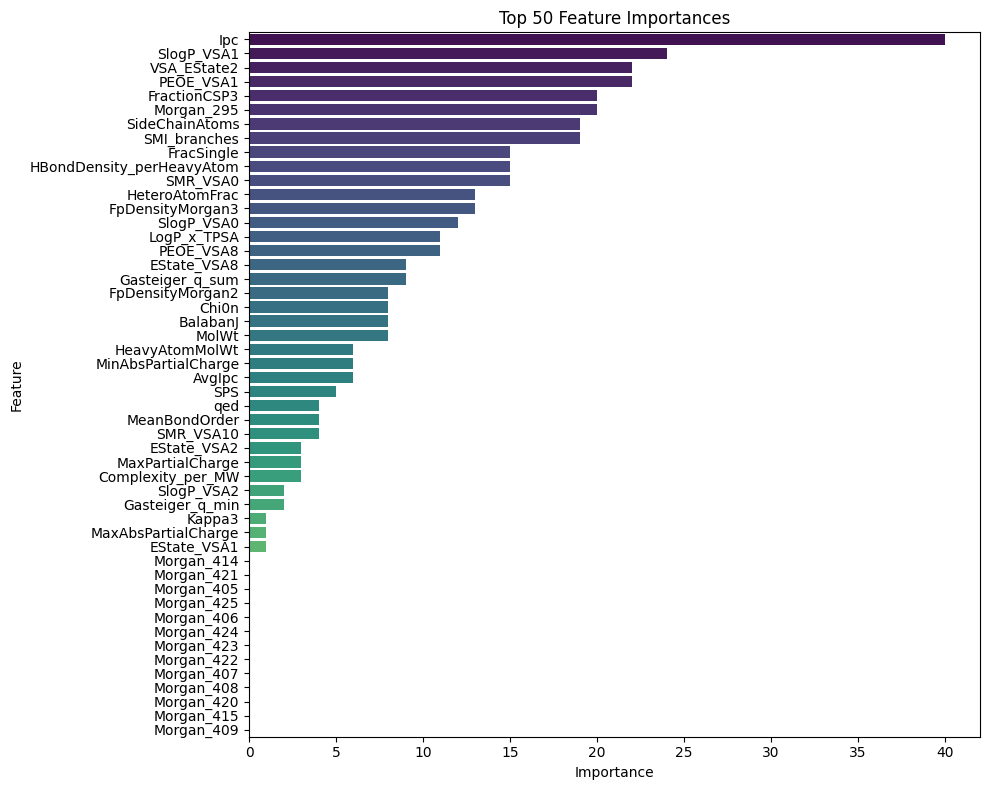

In [27]:
# plot of top 50 important features
importances = model.feature_importances_

feature_names = X.columns
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})
feature_importances = feature_importances.sort_values(by='importance', ascending=False).head(50)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('Top 50 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f'Metal_feature_importances_{timestamp}.png')
plt.show()



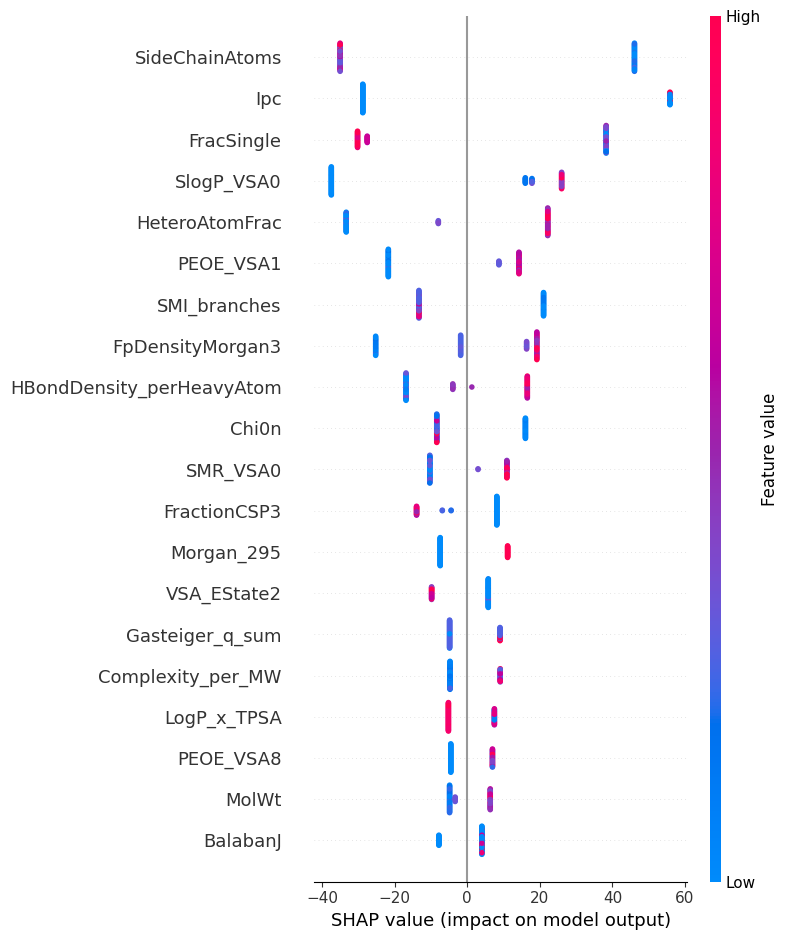

In [28]:
# shap plot

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid, show=False)
plt.savefig(OUTPUT_DIR / f'metal-containing (coordination_complex)_shap_summary_{timestamp}.png')


# so sánh kết quả giữa 2 nhóm

ta có thể thấy có sự thay đổi rõ rệt về độ chính xác cũng như các đặc trưng quan trọng giữa 2 nhóm hợp chất. Điều này chứng tỏ nhận định về sự khác biệt trong cấu trúc mạng tinh thể cũng như liên kết nội phân tử sẽ làm ảnh hưởng đến hiệu suất của mô hình dự đoán. Do đó, việc chọn lọc dữ liệu sẽ giúp cải thiện đáng kể hiệu suất của mô hình dự đoán nhiệt độ nóng chảy.